In [2]:
#imports
import collections
import numpy as np
import pandas as pd
import sqlite3
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# Connect to DB and read all data
conn = sqlite3.connect('bee_sightings_native.sqlite')
bee_data = pd.read_sql('SELECT * from bee_sightings', conn)
bee_data.replace('', np.nan, inplace=True)
bee_data.head()

,bee_id,common_name,dateidentified,latitude,longitude,floral_host,sightingstatus_id,native_status
0,21041,Yellow-faced bumble bee,2017-08-05 00:00:00.000000,45.524403,-122.637095,None,1,None
1,20632,Yellow-faced bumble bee,2017-08-08 00:00:00.000000,45.494031,-122.427821,Joe Pye weed,1,Non-native
2,20423,Obscure bumble bee,2017-08-06 00:00:00.000000,45.584405,-122.723538,None,1,None
3,20263,Bumble bee,2017-08-03 00:00:00.000000,45.494263,-122.427542,Aster Douglasii,1,Native
4,19923,Bumble bee,2017-07-27 00:00:00.000000,45.539996,-122.571588,NaN,1,None


In [4]:
# Most popular plant? 
    # Which plant saw the most visits? 
        # Ceanothus, blackberry, rhododendron
    #The largest diversity of visitors.
        # 
    
# Plot bee species on x-axis, flower species on y-axis. Any cool clustering happening? Color bee species differently
  #to see if bee species cluster around certain plant species
    
# Generalization ratio: calculate the variance in visits for a particular species across all flower species. Fewer
  #the species, less the variance, and thus the more specialist a species might be.



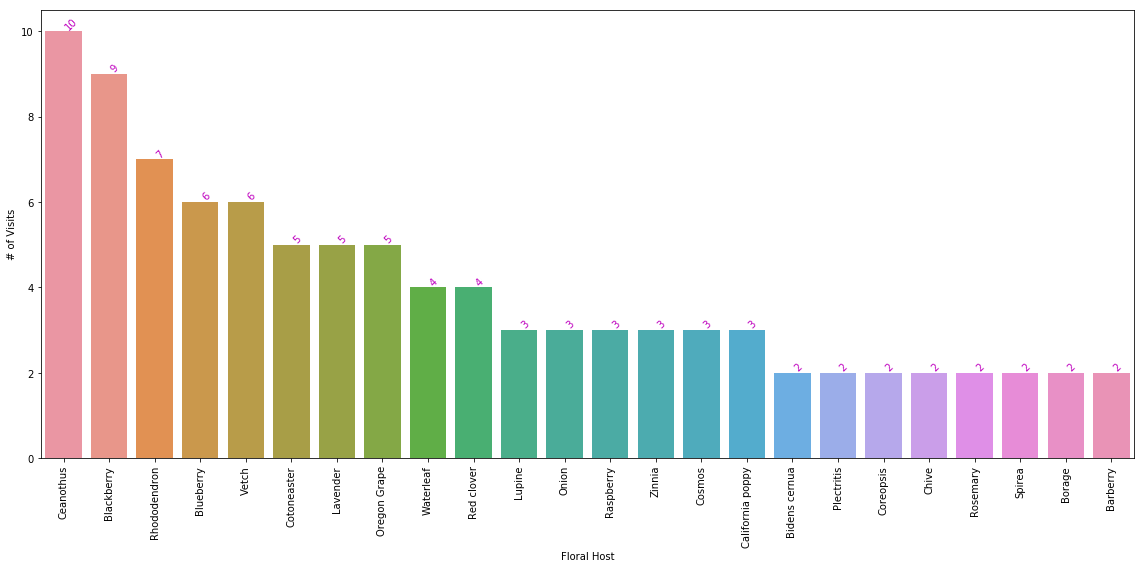

In [5]:
# Query for total abundance/count of by plant species name within verified sightings
verified_sightings = bee_data[(bee_data.sightingstatus_id == 2) & bee_data['floral_host'].notnull()]
numVisits = pd.DataFrame(verified_sightings.groupby(['floral_host']).size())
numVisits.columns = ['Count']
numVisits = numVisits[numVisits['Count'] > 1]
numVisits = numVisits.sort_values(['Count'], ascending=False)

# Create a figure
plt.figure(figsize=(16, 8))
# Plot barchart with DataFrame index as x values
ax = sns.barplot(numVisits.index, numVisits.Count)
ax.get_yaxis().set_major_formatter(plt.FuncFormatter(lambda x, loc: '{:,}'.format(int(x))))
ax.set(xlabel='Floral Host', ylabel='# of Visits')
# add proper Visits values as x labels
ax.set_xticklabels(numVisits.index, size=10)
for item in ax.get_xticklabels(): item.set_rotation(90)
for i, v in enumerate(numVisits['Count'].iteritems()):
    ax.text(i, v[1], '{:,}'.format(v[1]), color='m', va='bottom', rotation=45, size=10)
plt.tight_layout()
plt.show()

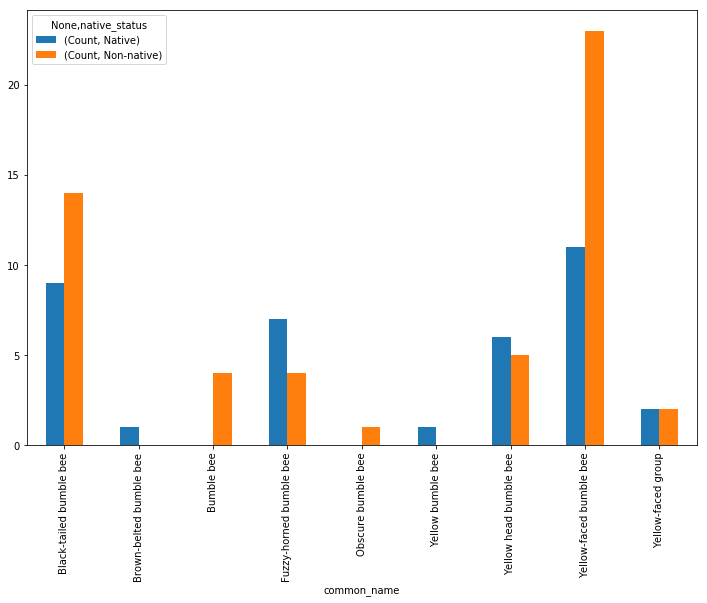

In [14]:
# Plot total bee species diversity on the y-axis, and Native, Non-native on the x-axis.
verified_sightings
nativeNon = pd.DataFrame(verified_sightings.groupby(['common_name', 'native_status']).size())
nativeNon.columns = ['Count']
nativeNon

nativeNon.unstack(level=1).plot(kind='bar', subplots=False, figsize=(12,8))

In [7]:
verified_sightings

,bee_id,common_name,dateidentified,latitude,longitude,floral_host,sightingstatus_id,native_status
12,18882,Yellow-faced bumble bee,2017-07-07 00:00:00.000000,45.489315,-122.507107,Daisy,2,NaN
22,18595,White-shouldered bumble bee,2017-06-29 00:00:00.000000,45.535415,-122.304904,Vetch,2,None
23,18593,Yellow-faced bumble bee,2017-06-29 00:00:00.000000,45.535415,-122.304904,Blackberry,2,Non-native
24,18592,Yellow bumble bee,2017-06-29 00:00:00.000000,45.535415,-122.304904,Vetch,2,None
25,18591,Yellow head bumble bee,2017-06-29 00:00:00.000000,45.535415,-122.304904,Blackberry,2,Non-native
26,18590,Fuzzy-horned bumble bee,2017-06-29 00:00:00.000000,45.535415,-122.304904,Blackberry,2,Non-native
27,18576,Yellow head bumble bee,2017-06-29 00:00:00.000000,45.581211,-122.797297,Phacelia,2,None
51,17917,Yellow head bumble bee,2017-06-07 00:00:00.000000,45.535267,-122.305148,Vetch,2,None
52,17915,Obscure bumble bee,2017-06-07 00:00:00.000000,45.535031,-122.305453,Blackberry,2,Non-native
53,17914,Fuzzy-horned bumble bee,2017-06-07 00:00:00.000000,45.535057,-122.305276,Blackberry,2,Non-native


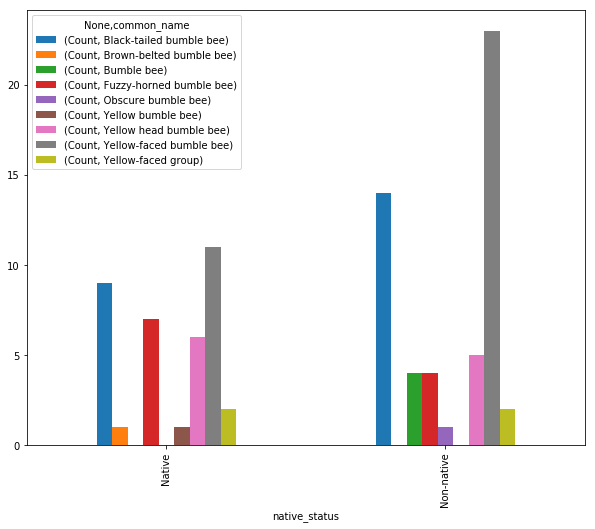

In [15]:
counts_compare = pd.DataFrame(verified_sightings.groupby(['native_status', 'common_name']).size())
counts_compare.columns = ['Count']
counts_compare.unstack(level=1).plot(kind='bar', subplots=False, figsize=(10,8))

AttributeError: 'AxesSubplot' object has no attribute 'ylabel'

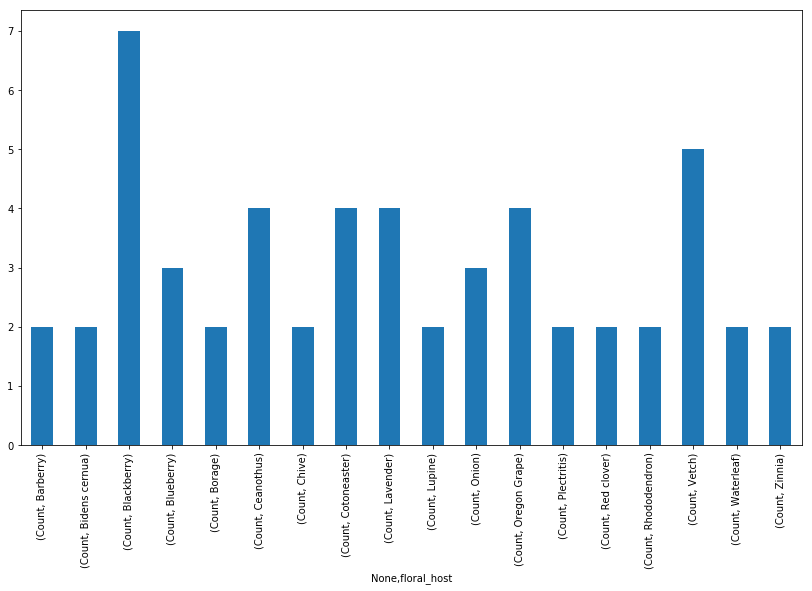

In [45]:
verified_sightings
bee_flower = pd.DataFrame(verified_sightings.groupby(['floral_host', 'common_name']).size())
bee_flower.columns = ['Count']
bee_flower['Count'] = 1
new = pd.DataFrame(bee_flower.groupby(['floral_host']).sum())
new = new[new['Count'] > 1]
plt new.unstack(level=1).plot(kind='bar', subplots=False, figsize=(14,8))